Multidimensional Arrays
=======================

# Part 0: datasets for the xarray tutorial

---
Questions:
- "What sample datasets will we use in this tutorial?"
objectives:
- "Learn about how we acquired climate reanalysis datasets"
keypoints:
- "refer to this page for access to the tutorial data"
---

### Reanalysis datasets:

We will be exploring the xarray architecture using some sample climate data from the European Centre for Medium-Range Weather Forecasts ([ECMWF](http://www.ecmwf.int/)). We will use their ERA-Intrim climate reanalysis project. You can download the data in netCDF format [here](http://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=sfc/). As is the case for many climate products, the process involves downloading large netCDF files to a local machine.

If you visit the ECMWF page you will find that you can download a large number of different climate fields. Here we have prepared tutorial examples around 4 variables. Note that we provide a full resolution (global) version as well as a subsetted version (Alaska). Choose the Alaska data if you are limited for space or processing power on your local computer. The tutorials exercises will work for either set of data.

| Dataset | Description | Size (MB) |
|:-------------:|:-------------:|:------------:|
| airtemp_global.nc | 2 meter air temperature | 3.0 |
| uwind_global.nc | wind blowing to the east | 3.0 |
| vwind_global.nc | wind blowing to the north | 3.0 |
| SST_global.nc | sea surface temperature | 3.0 |
| | | |
| airtemp_AK.nc | 2 meter air temperature | 0.1 |
| uwind_AK.nc | wind blowing to the east | 0.1 |
| vwind_AK.nc | wind blowing to the north | 0.1 |
| SST_AK.nc | sea surface temperature | 0.1 |

Note 1: when loading the data into xarray, we will use "engine = scipy" for all of the global datasets. You do not need to specify an engine for the AK datasets.

Note 2: many of our examples follow from and expand on xarray developer Stephan Hoyer's [blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python).

## Data Access:

* Alaska subsets are pre-loaded into the docker containers
* via ftp: host = ftp.cloudmaven.org (user/password to be provided)

In [3]:
import xarray as xr

def open_tutorial_data(kind='AK', **kwargs):
    if kind.upper() == 'AK':
        ds = xr.open_mfdataset('/Users/jhamman/Dropbox/src/tutorial_contents/nDarrays/data/*_AK.nc', **kwargs)
    elif kind.upper() == 'GLOBAL':
        ds = xr.open_mfdataset('/Users/jhamman/Dropbox/src/tutorial_contents/nDarrays/data/*_global.nc', **kwargs)
    return ds

In [4]:
ds = open_tutorial_data('AK')
ds

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 94, time: 13361)
Coordinates:
  * latitude   (latitude) float32 75.0 74.25 73.5 72.75 72.0 71.25 70.5 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * longitude  (longitude) float32 180.0 180.75 181.5 182.25 183.0 183.75 ...
Data variables:
    t2m        (time, latitude, longitude) float64 261.5 261.5 261.6 261.6 ...
    sst        (time, latitude, longitude) float64 271.5 271.5 271.5 271.5 ...
    u10        (time, latitude, longitude) float64 -4.047 -3.992 -3.936 ...
    v10        (time, latitude, longitude) float64 8.657 8.596 8.537 8.476 ...
Attributes:
    Conventions:  CF-1.0
    history:      2015-10-19 21:11:12 GMT by grib_to_netcdf-1.13.1: grib_to_n...

# Part 1: Introduction to multidimensional arrays

---
Questions:
- "When do we need to use multidimensional arrays?"
- "What are current challenges is manipulating these datasets?"
objectives:
- explore how most people currently handle these types of datasets
- discuss how current methods are limiting the science that can be accomplished
keypoints:
- unlabelled, N-dimensional arrays of numbers (e.g. NumPy's ndarray) are the most widely used data structure in scientific computing
- these arrays lack meaningful metadata, so users must track indices in an arbitrary fashion
- in-memory operations, needed to process and visualize large arrays, are reaching limits as datasets grow in size
---
### Overview:

Unlabelled, N-dimensional arrays of numbers, such as NumPy's ndarray, are the most widely used data structure in scientific computing. Geoscientists have a particular need for structuring their data as arrays. For example, we commonly work with sets of climate variables (e.g. temperature and precipitation) that vary in space and time and are represented on a regularly-spaced grid. Often we need to subset a large global grid to look at data for a particular region, or select a specific time slice. Then we might want to apply statistical functions to these subsetted groups to generate summary information.

<br>
<img src="http://xarray.pydata.org/en/stable/_images/dataset-diagram.png" width = "800" border = "10">
<br>

> ## Isn't this the same as raster processing?
> The tools in this tutorial have some similarity to raster image processing tools.
> Both require computational engines that can manipulate large stacks of data formatted as arrays.
> Here we focus on tools that are optimized to handle data that have many variables spanning dimensions
> of time and space. See the raster tutorials for tools that are optimized for image processing of remote sensing datasets.


### Conventional Approach: Working with Unlabelled Arrays

Multidimensional array data are often stored in user-defined binary formats, and distributed with custom Fortran
or C++ libraries used to read and process the data. Users are responsible for setting up their own file structures and custom codes to handle these files. Subsetting the data involves reading everything into an in-memory array, and then using a series of nested loops with conditional statements to look for a specific range of index values associated with the temporal or spatial slice needed. Also, clever use of matrix algebra is often used to summarize data across spatial and temporal dimensions.

### Challenges:

The biggest challenge in working with N-dimensional arrays in this fashion is the fact that the data are almost disassociated from their metadata. Users are left with the task of tracking the meaning behind array indices using domain-specific software, often leading to inefficiencies and errors. Common pitfalls often occur in in the form of questions like "is the time axis of my array in the first or third index position?", or "does my array of timestamps still align with my data after resampling?".

### The network Common Data Format

The network Common Data Form, or [netCDF](http://www.unidata.ucar.edu/software/netcdf/docs/), was created in the early 1990s, and set out to solve some of the challenges in working with N-dimensional arrays. Netcdf is a collection of self-describing, machine-independent binary data formats and software tools that facilitate the creation, access and sharing of scientific data stored in N-dimensional arrays, along with metadata describing the contents of each array. Netcdf was built by the climate science community at a time when regional climate models were beginning to produce larger and larger output files. Another  format, [HDF5](https://www.hdfgroup.org/), has been used for many applications including distribution of remote sensing datasets. It turns out these two formats are now merging, such that the latest version netCDF-4 is the HDF5 format but with some restrictions.

One benefit of Common Data Formats is that they are structured in ways that enable rapid subsetting and analysis using simple command line tools. For example, the climate community has developed their own [netCDF toolkits](http://www.unidata.ucar.edu/software/netcdf/software.html) that accomplish tasks like subsetting and grouping. Similar tools exist for [HDF5](https://support.hdfgroup.org/HDF5/Tutor/HDF5Intro.pdf). Therefore many researchers utilize these tools exclusively in their analysis.

### NetCDF in practice

NetCDF has been widely adopted as a standard format for distributing N-dimensional arrays. Although many geoscience communities rely entirely on existing NetCDF software tools for processing and visualizing their data, others simply use NetCDF as a convenient format for serializing their arrays. In many applications, existing NetCDF tools do not provide the flexibility needed for a specific research question, and users end up reading arrays into memory. They then perform statistical and subsetting operations using conventional coding methods (e.g. looping over array indices) described above.

### Handling large arrays

The NetCDF format has no limit on file sizes. However, any analysis tools that read data from a NetCDF array into memory for some computational operation will be limited by that particular machine's available memory. As many multidimensional datasets grown in size, for example due to increases in model resolution and remote sensing capabilities, we are becoming increasingly limited in our ability to handle these large datasets.

# xarray architecture

---
questions:
- "What functionality does the xarray library offer?"
- "What are the benefits and limitations of this library?"
- "What is the fundamental architecture of xarray data objects?"
objectives:
- "learning the xarray data model"
- "selection and subsetting of array datasets using labeled indexing"
keypoints:
- "xarray is build on the netCDF data model"
- "xarray has two main data structures: DataArray and Dataset"
- "DataArrays store the multi-dimensional arrays"
- "Datasets are the multi-dimensional equivalent of a Pandas dataframe"
---

### What is xarray?

* originally developed by employees (Stephan Hoyer, Alex Kleeman and Eugene Brevdo) at [The Climate Corporation](https://climate.com/)
* xaray extends some of the core functionality of the Pandas library:
    * operations over _named_ dimensions
    * selection by label instead of integer location
    * powerful _groupby_ functionality
    * database-like joins

### When to use xarray:

* if your data are multidimensional (e.g. climate data: x, y, z, time)
* if your data are structured on a regular grid
* if you can represent your data in netCDF format

### Basic xarray data structures:
* NetCDF forms the basis of the xarray data structure
* two main data structures are the `DataArray` and the `Dataset`

#### `DataArray`
* the `DataArray` is xarray's implementation of a labeled, multi-dimensional array
* the `DataArray` has these key properties:
  * `data`: N-dimensional array (NumPy or dask) holding the array's values,
  * `dims`: dimension names for each axis,
  * `coords`: dictionary-like container of arrays that label each point, and
  * `attrs`: ordered dictionary holding metadata

<br><br><br>
<img src="http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png" width = "800" border = "10">
<br><br><br>
* dimensions (x, y, time); variables (temp, precip); coords (lat, long); attributes


### `Dataset`
* xarray's multi-dimensional equivalent of a Pandas `DataFrame`
* dict-like container of DataArray objects with aligned dimensions
* Datasets have these key properties:
  * `dims`: dictionary mapping from dimension names to the fixed length of each dimension,
  * `data_vars`: dict-like container of `DataArrays` corresponding to data variables,
  * `coords`: dictionary-like container of `DataArrays` intended to label points used in data_vars
  * `attrs`: ordered dictionary holding metadata

### begin by importing the xarray library

In [5]:
import xarray as xr

### Open the dataset

First we [open](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) the data and load it into a `Dataset`. (Note: the choice of engine depends on the format of the netCDF file. See our [dataset description](../00-datasets) lesson).

In [6]:
ds = xr.open_dataset('/Users/jhamman/Dropbox/src/tutorial_contents/nDarrays/data/airtemp_global.nc')

(__NOTE__: here and elsewhere, replace `<rootDir>` with the full path to your own data directory)

You'll notice this seemed to go very fast. That is because this step does not actually ask Python to read the data into memory. Rather, Python is just scanning the contents of the file. This is called _lazy loading_.

## `Dataset` Properties

Next we will ask xarray to display some of the [parameters](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) of the `Dataset`. To do this simply return the contents of the `Dataset` variable name:

In [7]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 13361)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
Data variables:
    t2m        (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...
Attributes:
    Conventions:  CF-1.0
    history:      2015-10-19 21:11:12 GMT by grib_to_netcdf-1.13.1: grib_to_n...

> ## Displaying `Dataset` properties
> Try looking up the coordinates (coords), attributes (attrs) and data variables (data_vars) for our existing dataset.
> Look at the output and think about what this tells us about our sample dataset.


### Extracting `DataArrays` from a `Dataset`

We have queried the dataset details about our `Datset` dimensions, coordinates and attributes. Next we will look at the variable data contained within the dataset. In the graphic above, there are two variables (temperature and precipitation). As described above, xarray stores these observations as a `DataArray`, which is similar to a conventional array you would find in numpy or matlab.

Extracting a `DataArray` for processing is simple. From the `Dataset` metadata shown above, notice that the name of the climate variable is `'t2m'` (2 meter air temperature). Suppose we want to extract that array for processing and store it to a new variable called `temperature`:

In [8]:
temperature = ds['t2m']

Now, take a look at the contents of the `temperature` variable. Note that the associated coordinates and attributes get carried along for the ride. Also note that we are still not reading any data into memory.

# Part 2: Label-based indexing

---
Questions:
- "How does the labeling of dimensions enhance the xarray workflow?"
objectives:
- "learning to locate data in xarray using integer- and label-based lookups"
- "using named dimensions to located data"
keypoints:
- "xarray's labeled dimensions free the user from having to track positional ordering of dimensions when accessing data, creating a more simplified workflow"
---

### Indexing

Indexing is used to select specific elements from xarray files. Let's select some data from the 2-meter temperature `DataArray`. We know from the previous lesson that this `DataArray` has dimensions of time and two dimensional space (latitude and longitude).

You are probably already used to conventional ways of indexing an array. You will know in advance that the first array index is time, the second is latitude, and so on. You would then use [positional indexing](http://xarray.pydata.org/en/stable/indexing.html)):

In [9]:
ds['t2m'][0, 0, 0]

<xarray.DataArray 't2m' ()>
array(241.95071989464037)
Coordinates:
    longitude  float32 0.0
    latitude   float32 90.0
    time       datetime64[ns] 1979-01-01T06:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

This method of handling arrays should be familiar to anyone who has worked with arrays in MATLAB or NumPy. One challenge with this approach: it is not simple to associate an integer index position with something meaningful in our data. For example, we would have to write some function to map a specific date in the time dimension to its associated integer. Therefore, xarray lets us perform positional indexing using labels instead of integers:

In [10]:
ds['t2m'].loc['1979-01-01T06:00:00']

<xarray.DataArray 't2m' (latitude: 241, longitude: 480)>
[115680 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
    time       datetime64[ns] 1979-01-01T06:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

This is great, but we still need to be keeping track of the fact that our index position 1 is the time dimension, position 2 is latitude, etc. So rather than looking up our dimension by position, xarray enables us to use the dimension name instead:

In [11]:
ds['t2m'].isel(time=0, latitude=0, longitude=0)

<xarray.DataArray 't2m' ()>
array(241.95071989464037)
Coordinates:
    longitude  float32 0.0
    latitude   float32 90.0
    time       datetime64[ns] 1979-01-01T06:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

Here, the `isel` method refers to a selection by integer position. Finally, we can combine the benefits of both a labeled index and a named dimension as follows:

In [12]:
ds['t2m'].sel(time='1979-01-01T06:00:00', latitude=75.0, longitude=180.0)

<xarray.DataArray 't2m' ()>
array(261.47730710087217)
Coordinates:
    longitude  float32 180.0
    latitude   float32 75.0
    time       datetime64[ns] 1979-01-01T06:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

> ## Slicing the data
> So far we have selected either a single array element, or all the elements along a dimension. Try using the __slice__
> function to select some range of data along a dimension


# Part 4: Plotting

---
Questions:
- "Does xarray have tools for visualizing the data?"
objectives:
- "learn simple methods to visualize subsets of xarray data in 1 or 2-dimensions"
keypoints:
- "xarray has plotting functinality that is a thin wrapper around the Matplotlib library"
- "xarray uses syntax and function names from Matplotlib whenever possible"
---

### Plotting data in 1 dimension

Let's start visualizing some of the data slices we've been working on so far. We will begin by creating a new variable for plotting a 1-dimensional time series:

In [13]:
time_series = ds['t2m'].sel(time=slice('1979-01-01T06:00:00', '1979-06-01T06:00:00'), latitude=75.0, longitude=180.0)

xarray has some very simple tools to enable quick visualizations of the data. Try this:

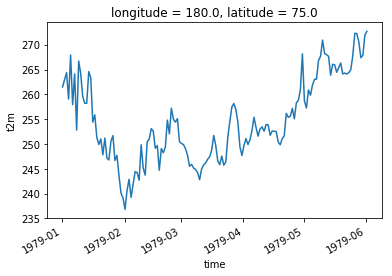

In [14]:
%matplotlib inline
time_series.plot()

Your plots can be [customized](http://xarray.pydata.org/en/stable/plotting.html) using syntax that is very similar to Matplotlib. For example:

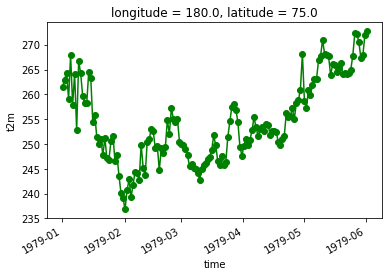

In [15]:
time_series.plot.line(color='green', marker='o')

### Plotting data in 2 dimensions

Since many xarray applications involve geospatial datasets, xarray's plotting extends to maps in 2 dimensions. Let's first select a 2-D subset of our data by choosing a single date and retaining all the latitude and longitude dimensions:

In [16]:
map_data = ds['t2m'].sel(time='1979-01-01T06:00:00')

Note that in the above label-based lookup, we did not specify the latitude and longitude dimensions, in which case xarray assumes we want to return all elements in those dimensions.

Now, similar to what we did for 1-D plots, simply call do the following to generate a map:

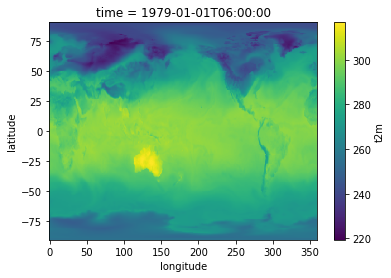

In [17]:
map_data.plot()

Customization can occur following standard Matplotlib syntax. Note that before we use matplotlib, we will have to import that library:

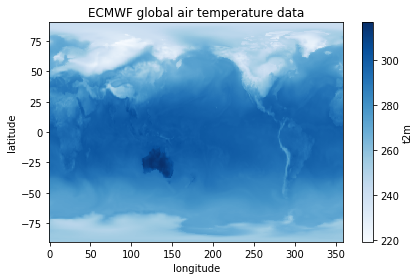

In [18]:
import matplotlib.pyplot as plt
map_data.plot(cmap=plt.cm.Blues)
plt.title('ECMWF global air temperature data')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()

Further customization can be added using Cartopy to add a projection, coastlines, etc.:

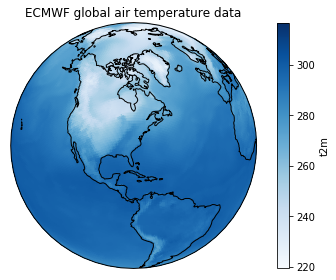

In [19]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))

map_data.plot(ax=ax, cmap=plt.cm.Blues, transform=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

plt.title('ECMWF global air temperature data')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()

# Part 5: Arithmetic and aggregation

---
Questions:
- "How do I perform simple arithmetic operations on xarray objects?"
- "How do I calculate statistics along a dimension of an xarray object?"
objectives:
- "using dimension names rather than integer axis numbers to perform common statistical arithmetic and aggregation functions"
keypoints:
- "xarray's labeled dimensions enable simplified arithmetic and data aggregation, enabling many powerful shortcuts"
---

### Arithmetic

Suppose we want to plot the difference in air temperature between January 1 in 1979 versus 1980. We can do this by taking advantage of xarray's labeled dimensions to simplify arithmetic operations on `DataArray` objects:

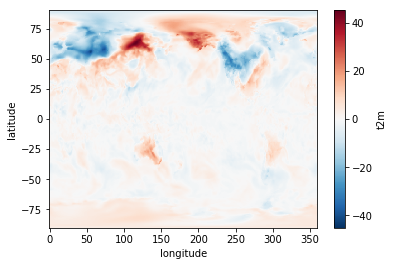

In [20]:
temperature1 = ds['t2m'].sel(time='1979-01-01T06:00:00')
temperature2 = ds['t2m'].sel(time='1980-01-01T06:00:00')
delta = temperature1 - temperature2
delta.plot()

Note that the subtraction is automatically vectorized over all array values, as in numpy.

### Mathematical functions

Now, sometimes we need to apply mathematical functions to array data in our analysis. A good example is wind data, which are often distributed as orthogonal "u" and "v" wind components. To calculate the wind magnitude we need to take the square root of the sum of the squares. For this we use numpy [ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) commands that can operate on a `DataArray`. Let's look at our wind datasets:

In [21]:
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
wind = open_tutorial_data('AK').sel(time="1984-01-01T06:00:00")
# wind = xr.open_mfdataset(r'c:/work/mnt/ecmwf/*wind_AK.nc')
windspeed = xu.sqrt(wind.u10**2+wind.v10**2)

Notice we introduced something new in opening our data. Since we need to access two netCDF files, we used xarray's [open_mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html?highlight=open_mfdataset), which allows us to read any number of netCDF files into a single `Dataset`. Here we use a wildcard search to find the two wind datasets. Note that xarray exposes a wide range of mathematical functions this way, such as  `sin`, `cos`, etc.

Now to plot the data:

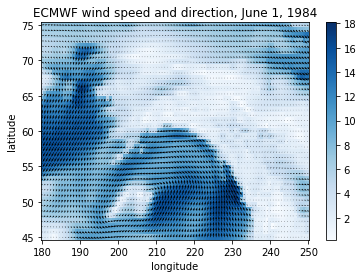

In [22]:
windspeed.plot.pcolormesh(cmap=plt.cm.Blues)
plt.title('ECMWF wind speed and direction, June 1, 1984')
plt.ylabel('latitude')
plt.xlabel('longitude')
x = windspeed.coords['longitude']
y = windspeed.coords['latitude']
plt.quiver(x, y, wind['u10'], wind['v10'])

### Aggregation

Aggregation methods can be applied to a `DataArray` over a specified dimension. Suppose we want to calculate the average June/July/August temperature for a particular year. Let's create a `DataArray` that slices out those months of data for a particular year:

In [23]:
JJA = ds['t2m'].sel(time=slice('1979-06-01T06:00:00','1979-09-01T06:00:00'))

Now we simply apply the `mean` aggregation method over the time dimension and plot the result:

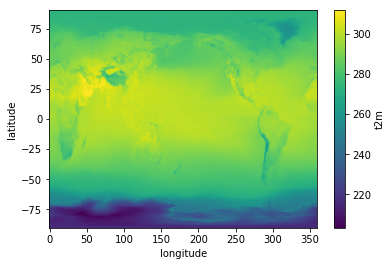

In [24]:
JJA.mean(dim='time').plot()

> ## Aggregation
> Using the JJA DataArray created above, calculate the maximum air temperature during the JJA period at each latitude and longitude.
> Plot the result in degrees Celsius as a map. Also, calculate the standard deviation in global air temperature during the JJA period,
> and plot the results as a 1-D time series.

# Part 6: Groupby processing

---
Questions:
- "What is groupby processing and in what cases is it useful for scientific analysis of multidimensional arrays?"
objectives:
- "Learn the concepts of split/apply/combine and experimenting with xarray groupby processing"
keypoints:
- "xarray provides Pandas-like methods for performing data aggregation over defined groupings in the data"
---

## GroupBy processing
We often want to build a time series of change from spatially distributed data. For example, suppose we need to plot a time series of the global average air temperature across the entire period of our climate data record. To accomplish this, xarray has powerful [GroupBy](http://xarray.pydata.org/en/stable/groupby.html) processing tools, similar to the well known GROUP BY processing used in SQL. In all cases we **split** the data, **apply** a function to independent groups, and **combine** back into a known data structure.

### Groupby processing: split

We can `groupby` the name of a variable or coordinate. Either returns an xarray `groupby` object:

In [25]:
ds['t2m'].groupby('time')

### Groupby processing: apply
Next we `apply` a function across the groupings set up in the xarray `groupby` process. When providing a single dimension to the `groupby` command, `apply` processes the function across the remaining dimensions. We could do the following:

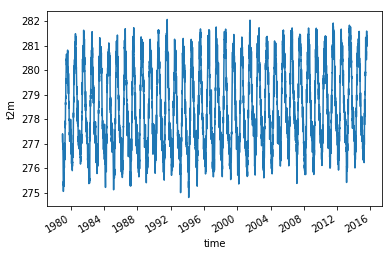

In [ ]:
def mean(x):
    return x.mean()

ds['t2m'].groupby('time').apply(mean).plot()

However, groupby objects have convenient shortcuts:

In [ ]:
ds['t2m'].groupby('time').mean().plot()

This is the daily global average air temperature during the entire period of record.

> ## groupby
> Above we calculated daily global averages. Try to calculate the global
_annual_ average instead, and plot the results as a 1-D time series.

As a final example, here's a very interesting way to explore seasonal variations in temperature data using xarray:

In [ ]:
ds_by_season = ds['t2m'].groupby('time.season').mean('time')
t2m_range = abs(ds_by_season.sel(season='JJA') - ds_by_season.sel(season='DJF'))
t2m_range.plot()

# Part 7: Out-of-core computation

---
Questions:
- "How can we do computations on array datasets that are too large to fit into memory on a local machine?"
objectives:
- "understand best practices for reading and storing large gridded datasets"
- "using multi-threading libraries to facilitate manipulation of larger-than-memory grids"
keypoints:
- dask integration with xarray allows you to work with large datasets that "fit on disk" rather than having to "fit in memory".
- It is important to chunk the data correctly for this to work.
---

## Handling large grids

When xarray carries out processing on an array it must load it into memory. Many datasets are becoming too large for this to be carried out on a typical laptop. For this reason, xarray integrates with a parallel computing library called [Dask](http://xray.readthedocs.org/en/stable/dask.html). Dask uses task scheduling and blocked algorithms to enable processing of datasets that "fit on disk" even if they do not "fit in memory".

### Dask:
* dask.array = numpy + threading
* dask.bag = map, filter, toolz + multiprocessing
* dask.dataframe = pandas + threading

<br>
<img src="http://dask.pydata.org/en/latest/_images/collections-schedulers.png" width = "500" border = "10">
<br>

<br>
<img src="http://mrocklin.github.com/blog/images/dask/embarrassing.gif" width = "500" border = "10">
<br>

## Opening multiple netCDF files, and using Dask
We will use the [mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) option that opens multiple files as a single xarray dataset. This automatically invokes the dask functionality:

In [ ]:
ds = open_tutorial_data('global', chunks={'time': 50})

In [ ]:
ds

### Chunk sizes:
Without specifying chunk size, open_mfdataset chunks along existing dimensions. Getting the chunk size right is the crucial step to optimize working with xarray/dask. We recommend following [this advice](http://xarray.pydata.org/en/stable/dask.html?highlight=rechunk#chunking-and-performance). You should use chunk sizes of about 1 million elements. In our case: 480* 241 = 115680, so make the time chunk 10 to get around 1 million. Note that we are only chunking the time dimension. Choice depends on how you will be working with the data.

Now when can carry out any processes on the `Dataset`, `dask` will be invoked. It is wise to include the `ProgressBar` tool from  `dask.diagnostics` to track the processing:

In [39]:
# from dask.dot import dot_graph
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [36]:
# from dask.diagnostics import ProgressBar
# with ProgressBar():
seasons = ds['sst'].groupby('time.season').mean()

In [37]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    seasons = seasons.compute()

/Users/jhamman/anaconda/envs/ndarrays/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [38]:
visualize([prof, rprof, cprof])

Column(id='87466024-8c1c-4458-999b-3252e4d805af', ...)

# Part 8: Masking

---
Questions:
- "What is masking and how can it be used to analyze portions of a dataset"
objectives:
- "Learn the concepts of masking with xarray."
keypoints:
- "xarray provides tools for creating and analyzing masked data."
---

## Masking with where:

So far we have used indexing to return subsets of the original. The subset array shape will be different from the original. However, we often want to retain the array shape and mask out some observations. There are applications here in remote sensing, land cover modeling, etc.

Suppose we need to determine which grid cells had temperatures > 20 deg C on June 21, 1984? We will use [where()](http://xarray.pydata.org/en/stable/indexing.html#masking-with-where) for this selection:

/Users/jhamman/anaconda/envs/ndarrays/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


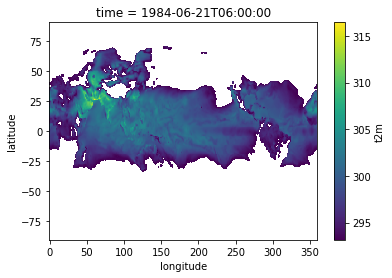

In [40]:
ds.sel(time="1984-06-21")['t2m'].where(ds.t2m > 293.15).plot()

Another common Earth science application is to create land cover masks. Let's use the sea surface temperature field (sst) to build a land and ocean mask. We'll assign land a value of 1, and ocean a value of 2 (arbitrary). Note that the sst field currently has NaN for all land surfaces:

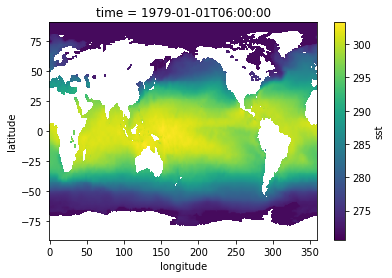

In [41]:
ds.sst.isel(time=0).plot()

### Buliding the mask:

Here we'll use some lower-level numpy commands to build the mask (and we'll need to import the numpy library). The mask number depends on whether the cells are finite or NaN:

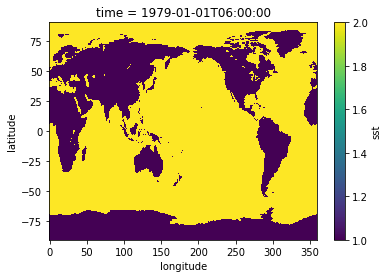

In [42]:
import numpy as np
mask_ocean = 2 * np.ones((ds.dims['latitude'], ds.dims['longitude'])) * np.isfinite(ds.sst.isel(time=0))  
mask_land = 1 * np.ones((ds.dims['latitude'], ds.dims['longitude'])) * np.isnan(ds.sst.isel(time=0))  
mask_array = mask_ocean + mask_land
mask_array.plot()

### Mask as Coordinates
We can keep the mask as a separate array entity, or, if we are using it routinely, there are advantages to [adding it](http://xarray.pydata.org/en/stable/data-structures.html#dataarray-coordinates) as a coordinate to the `DataArray`:

In [43]:
ds.coords['mask'] = (('latitude', 'longitude'), mask_array)
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 13361)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
    mask       (latitude, longitude) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
Data variables:
    sst        (time, latitude, longitude) float64 271.5 271.5 271.5 271.5 ...
    t2m        (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...
    u10        (time, latitude, longitude) float64 2.418 2.325 2.233 2.142 ...
    v10        (time, latitude, longitude) float64 -7.053 -7.077 -7.1 -7.123 ...
Attributes:
    Conventions:  CF-1.0
    history:      2015-10-29 19:35:37 GMT by grib_to_netcdf-1.13.1: grib_to_n...

Now that the mask is integrated into the coordinates, we can easily apply the mask using `where()`. We can integrate this with statistical functions operating on the array:

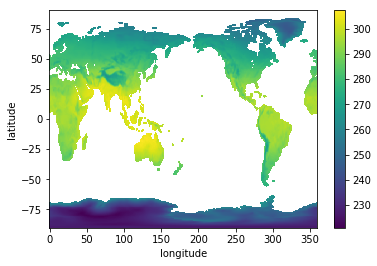

In [47]:
from dask.diagnostics import ProgressBar
# with ProgressBar():
ds['t2m'].mean('time').where(ds.mask == 1).plot()

> ## Calculating a climate index
> Climate scientists commonly calculate mean diferences in sea and land surface
> temperatures. These differences are used as an index and correlated to other earth
> surface processes, such as ecological change. Using the air temperature dataset,
> calculate the mean annual difference in SST and t2m?
